In [692]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
import sys

In [693]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [694]:
class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=3
            ),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=14400,
                out_features=20
            ),
            nn.Tanh(),
            nn.Linear(
                in_features=20,
                out_features=1
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x

In [695]:
class MRI(Dataset):
    def __init__(self):
        self.images = []
        self.labels = []
        self.mode = "train"
        data_path = Path("data/brain_tumor_dataset")
        image_path_list = list(data_path.glob("*/*.jpg"))
        for i in range(len(image_path_list)):
            if image_path_list[i].parent.stem == "no":
                self.labels.append(0)
            else:
                self.labels.append(1)
            img = cv2.imread(image_path_list[i])
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            self.images.append(img)
        self.labels = np.array(self.labels, dtype = np.float32)
        self.images = np.array(self.images, dtype=np.float32)
         
    def __getitem__(self, idx):
        
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def __len__(self):
        
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def normalize(self):
        self.images = self.images / 255.0

    def image_show(self, index):
        plt.imshow(self.images[index].reshape(self.images[index].shape[2], self.images[index].shape[1], self.images[index].shape[0]))
        title = "Yes" if self.labels[index] else "No"
        plt.title(f"Tumor Situation: {title}")
        plt.axis(False)
    
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

mri = MRI()
mri.normalize()
mri.train_val_split()

In [696]:
train_dataloader = DataLoader(mri, batch_size=18, shuffle=True)
val_dataloader = DataLoader(mri, batch_size=18, shuffle=False)
model = ModelV1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [697]:
EPOCHS = 150
for i in range(1, EPOCHS):
    losses = []
    for D in train_dataloader:
        optimizer.zero_grad()
        img = D['image'].to(device)
        label = D['label'].to(device)
        y_pred = model(img).squeeze()
        loss_fn = nn.BCELoss()
        loss = torch.sum(loss_fn(y_pred, label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (i+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.642684
Train Epoch: 20	Loss: 0.624983
Train Epoch: 30	Loss: 0.598181
Train Epoch: 40	Loss: 0.575395
Train Epoch: 50	Loss: 0.561515
Train Epoch: 60	Loss: 0.556319
Train Epoch: 70	Loss: 0.550278
Train Epoch: 80	Loss: 0.547719
Train Epoch: 90	Loss: 0.543750
Train Epoch: 100	Loss: 0.544073
Train Epoch: 110	Loss: 0.533274
Train Epoch: 120	Loss: 0.528087
Train Epoch: 130	Loss: 0.524587
Train Epoch: 140	Loss: 0.521632
Train Epoch: 150	Loss: 0.523611


In [698]:

model.eval()
mri.mode = "val"
outputs = []
y_pure_pred = []
y_true = []
with torch.no_grad():
    for D in val_dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_pred = model(image)
        predictions = (y_pred >= 0.5).float()

        outputs.append(predictions.cpu().numpy())
        y_pure_pred.append(y_pred.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()
y_pure_pred = np.concatenate(y_pure_pred).squeeze()

In [699]:
accuracy_score(y_true, outputs)

0.7142857142857143

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

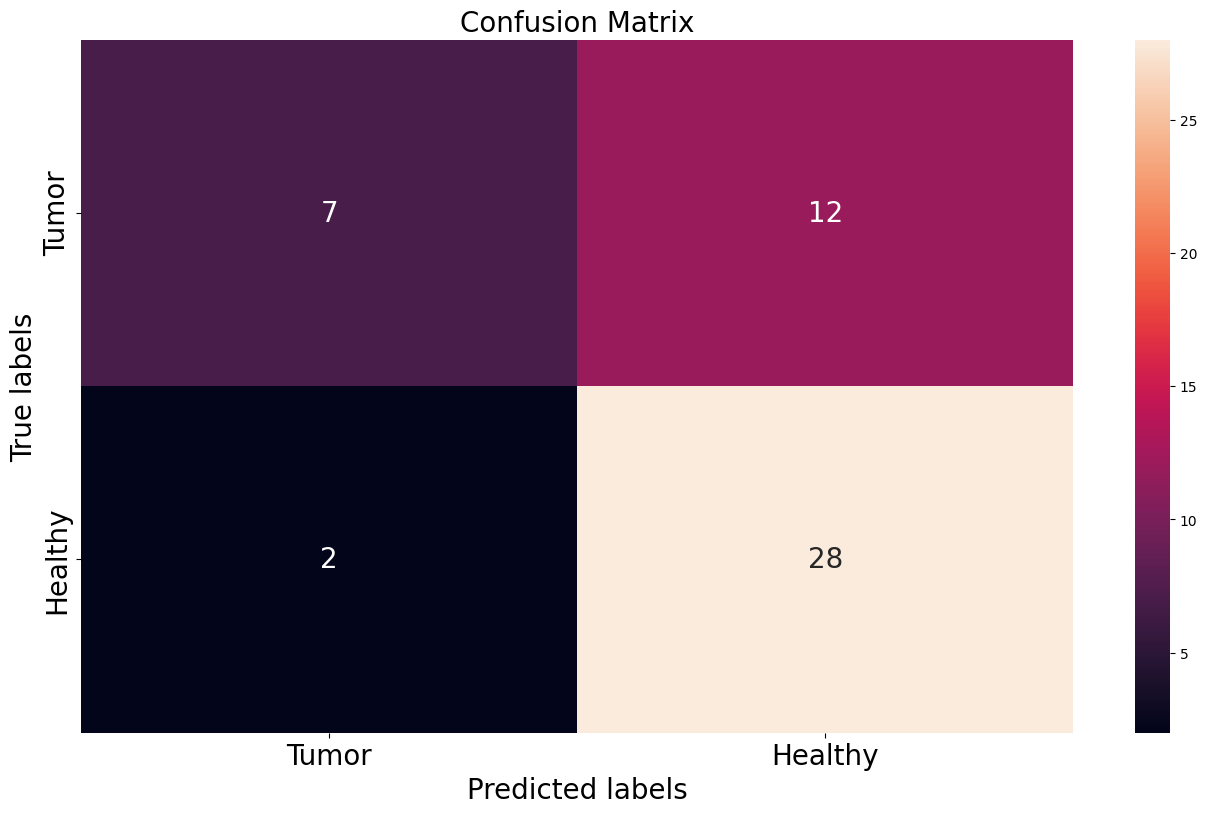

In [700]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, outputs)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [701]:
num_layers = 0
conv_layers = []
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
 ),
 Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=14400, out_features=20, bias=True)
   (2): Tanh()
   (3): Linear(in_features=20, out_features=1, bias=True)
 )]

In [702]:
for child in model.children():
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                conv_layers.append(layer)
                num_layers += 1
conv_layers, num_layers

([Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1)),
  Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))],
 2)

In [703]:
img = mri[1]['image']
img = torch.from_numpy(img).to(device).unsqueeze(dim=0)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))


Layer  1


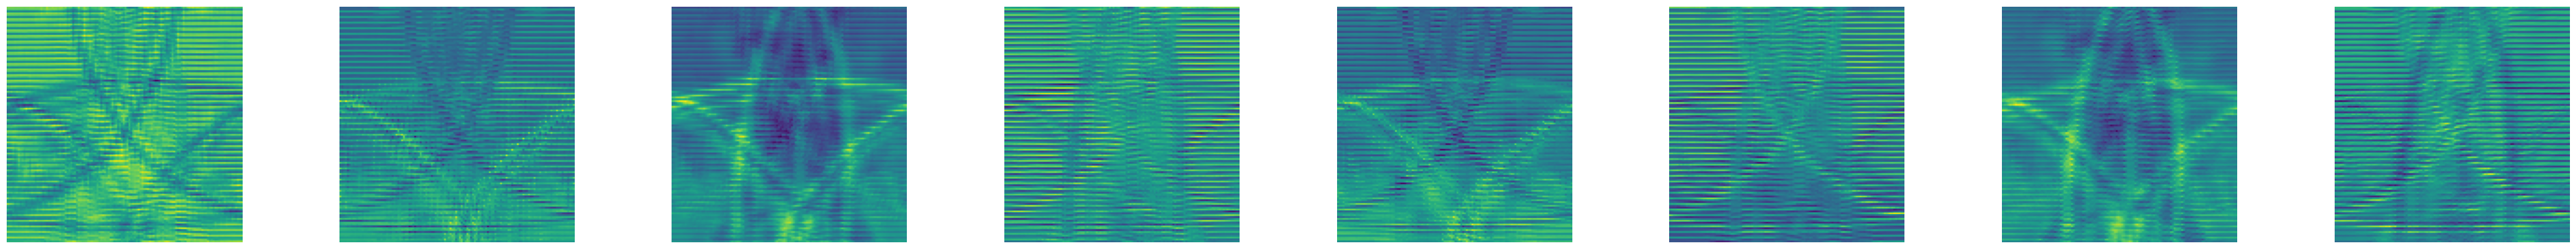

Layer  2


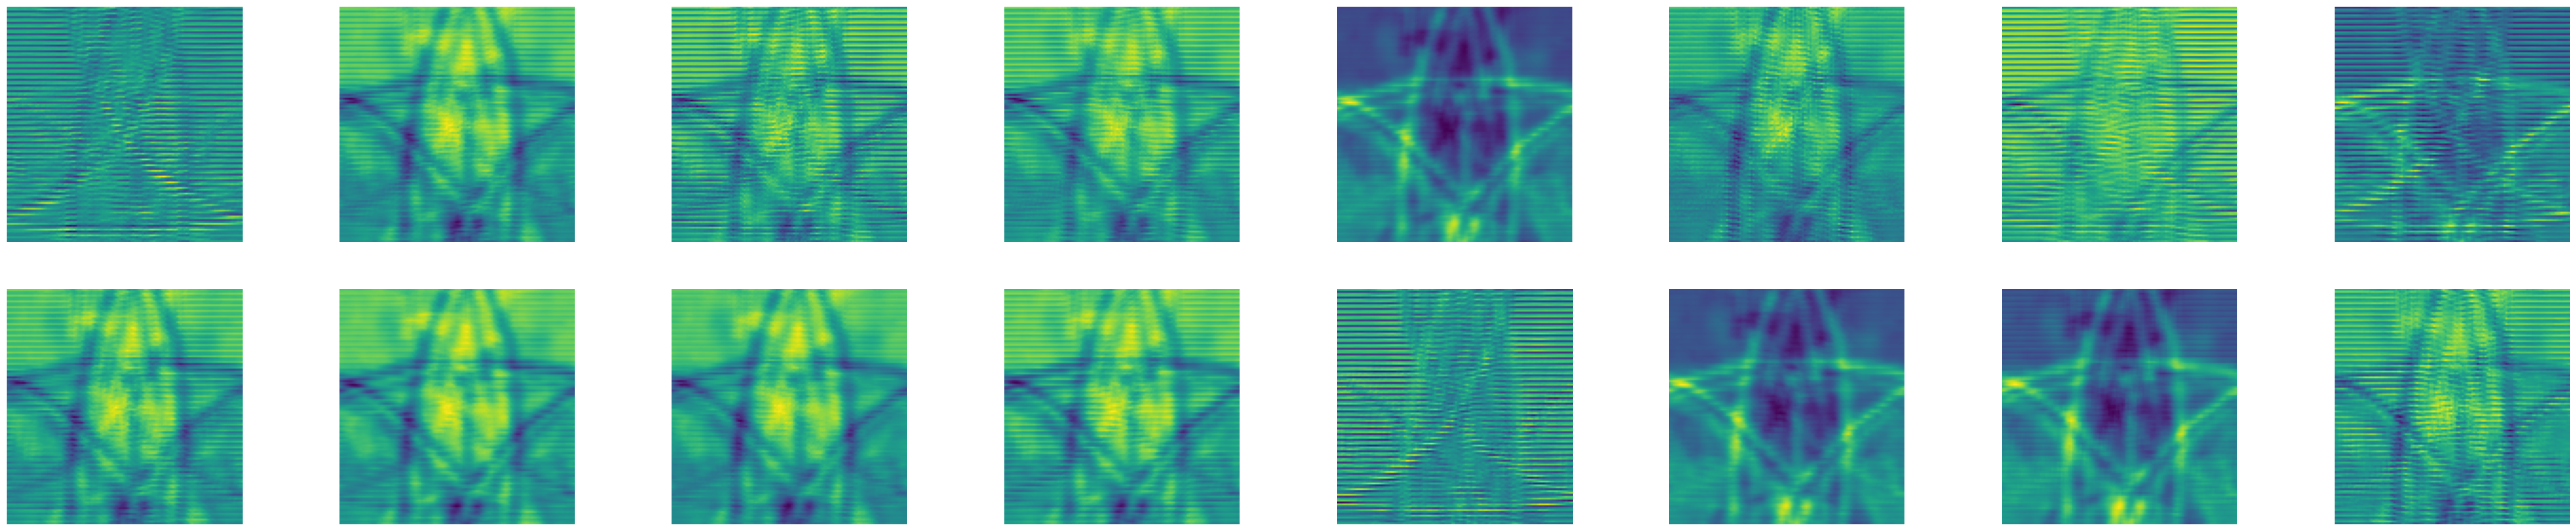

In [704]:
for num_layer in range(len(results)):
    plt.figure(figsize=(50, 10))
    layer_viz = results[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

In [938]:

train_transform = transforms.Compose([
    transforms.RandomRotation(135),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 5))
])

In [942]:
custom_img = Path("data/no/no 99.jpg")
custom_img = cv2.imread(custom_img)
custom_img = cv2.resize(custom_img, (128, 128))
b, g, r = cv2.split(custom_img)
img = cv2.merge([r, g, b])
img = torch.from_numpy(img).type(torch.float32) / 255
img = img.permute(2, 1, 0).unsqueeze(0)

model.eval()
with torch.no_grad():
    custom_pred = model(img.to(device))
    pred = (custom_pred >= 0.5).float()
print(custom_pred)
print(pred)


tensor([[0.6979]], device='cuda:0')
tensor([[1.]], device='cuda:0')


Text(0.5, 1.0, 'Pred: 1.0')

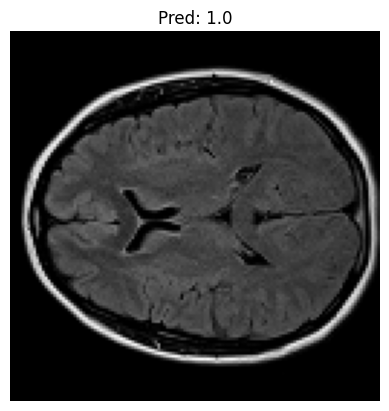

In [946]:
plt.imshow(img.squeeze().permute(1, 2, 0))
title = f"Pred: {pred[0][0]}"
plt.axis(False)
plt.title(title)

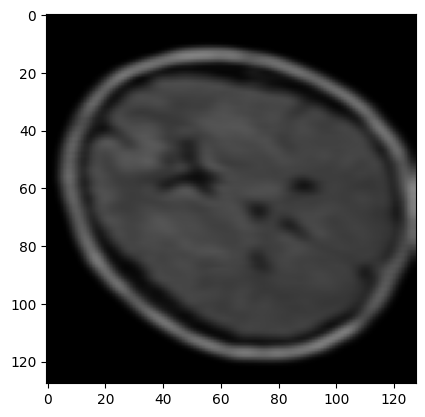

In [941]:
imgShow = img.squeeze()
imgShow = train_transform(imgShow)
plt.imshow(imgShow.permute(2, 1, 0).numpy())